In [1]:
%load_ext autoreload
%autoreload 2

In [11]:

import matplotlib.pyplot as plt
from PIL import Image
import glob
import re
import os
from src.consts import PATHS, MODEL_SIZES_PER_ARCH_TO_MODEL_ID
from src.types import DATASETS, MODEL_ARCH, DatasetArgs
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from collections import defaultdict
from tqdm.auto import tqdm
import src.plots as plots


from collections import defaultdict
import re
from PIL import Image, ImageDraw, ImageFont
from src.consts import GRAPHS_ORDER
from src.consts import get_model_by_cat_size




In [126]:
[
        *([(102, 106, 24, 40)] * 2),
        *([(102, 106, 24, 64.5)] * 2)
    ]

[(102, 106, 24, 40),
 (102, 106, 24, 40),
 (102, 106, 24, 64.5),
 (102, 106, 24, 64.5)]

In [280]:
from numpy import size

def create_figure(files, output_path, var1:bool):
    # Load and crop the images based on the trim parameters
    def crop_image(image_path, trim):
        image = Image.open(image_path)
        left, top, right, bottom = trim
        cropped = image.crop((left, top, image.width - right, image.height - bottom))
        return cropped

    def textsize(text, font):
        im = Image.new(mode="P", size=(0, 0))
        draw = ImageDraw.Draw(im)
        _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
        return width, height
    
    files = [
        files[0],files[2], files[1], files[3]
    ]
    # Trims are defined as (left, top, right, bottom) for PIL
    sizes = [
        *([(65, 106, 24, 59)]*2),
        (65, 106, 24, 15),
        (65, 106, 24, 15),
        (10, 80, 10, 200),
    ]
    if var1:
        sizes = [
            *([(40, 105, 12, 64)]*2),
            (40, 106, 12, 15),
            (40, 106, 12, 15),
            (10, 80, 10, 200),
        ]
    
    graphs = [crop_image(file, size) for file, size in zip(files, sizes)]
    g_top_left = graphs[0]
    g_top_right = graphs[1]
    g_bottom_left = graphs[2]
    g_bottom_right = graphs[3]
    legend = crop_image(files[0], (10, 80, 10, 195))  # Legend

    # Define dimensions for padding and spacing
    padding = 5
    label_width = 40
    title_height = 25
    legend_height = legend.height

    # Graph dimensions after cropping
    canvas_width = (g_top_left.width + g_top_right.width + 3 * padding + label_width)
    canvas_height = g_top_left.height + g_bottom_left.height + 4 * padding + title_height + legend_height

    # Create a canvas for the final figure
    canvas = Image.new("RGB", (canvas_width, canvas_height), "white")
    draw = ImageDraw.Draw(canvas)

    font = ImageFont.load_default(size = 20)
    small_font = ImageFont.load_default(size = 18)

    # Titles
    draw.text(
        (canvas_width // 4, padding),
        "Mamba-1", font=font, fill="black")
    draw.text(
        (3 * canvas_width // 4, padding),
        "Mamba-2",font=font,fill="black",
    )

    # Add graphs
    canvas.paste(g_top_left, (label_width + padding, title_height + padding))
    canvas.paste(g_top_right, (label_width + g_top_left.width + 2 * padding, title_height + padding))
    canvas.paste(g_bottom_left, (label_width + padding, title_height + g_top_left.height + 3 * padding))
    canvas.paste(g_bottom_right, (label_width + g_bottom_left.width + 2 * padding, title_height + g_top_right.height + 3 * padding))

    # Add rotated y-axis labels
    y_label1 = "  % accuracy"
    y_label2 = "% probability change"
    text_size1 = textsize(y_label1, small_font)
    text_size2 = textsize(y_label2, small_font)

    y_label_canvas1 = Image.new("RGB", (text_size1[0], text_size1[1]), "white")
    y_label_draw1 = ImageDraw.Draw(y_label_canvas1)
    y_label_draw1.text((0, 0), y_label1, font=small_font, fill="black")
    y_label_canvas1 = y_label_canvas1.rotate(90, expand=True)
    canvas.paste(y_label_canvas1, (padding, title_height + padding + (g_top_left.height + padding * 2 - text_size1[0]) // 2))

    y_label_canvas2 = Image.new("RGB", (text_size2[0], text_size2[1]), "white")
    y_label_draw2 = ImageDraw.Draw(y_label_canvas2)
    y_label_draw2.text((0, 0), y_label2, font=small_font, fill="black")
    y_label_canvas2 = y_label_canvas2.rotate(90, expand=True)
    canvas.paste(y_label_canvas2, (padding, title_height + g_top_left.height + 3 * padding + (g_bottom_left.height + padding * 2 - text_size2[0]) // 2))

    # Add legend (centered below)
    legend_x = (canvas_width - legend.width) // 2
    legend_y = title_height + g_top_left.height + g_bottom_left.height + 4 * padding
    canvas.paste(legend, (legend_x, legend_y))

    # Save the final image
    canvas.save(output_path)
    print(f"Figure saved at {output_path}")


# create_figure(graphs_files, "output_figure.png", False)

In [281]:
MODEL_TO_VERSION = {
    MODEL_ARCH.MAMBA1: "_v6",
    MODEL_ARCH.MINIMAL_MAMBA2_new: "_v6",
}
WS = ['9', '15']
results_dir_name = 'results'
# results_dir_name = "results_for_multi_plot"
pattern = fr"/state-spaces/(?P<model_id>[\w\.-]+)/info_flow(?P<version>[\w]*)/ds=(?P<dataset>[\w_]+)/ws=(?P<window_size>\d+)/{results_dir_name}/knockout_target=(?P<knockout_target>\w+)/(?P<metric>\w+).png"
metrics = ['accuracy', 'norm_change']

for window_size in WS:
    for knockout_target in ['last', 'relation', 'subject', ]:
        graphs_files = []
        for model, size in get_model_by_cat_size('large'):
            model_id = MODEL_SIZES_PER_ARCH_TO_MODEL_ID[model][size]
            model_dir = (
                PATHS.OUTPUT_DIR / f"{model_id}/info_flow{MODEL_TO_VERSION[model]}"
            )
            for file in model_dir.rglob('*.png'):
                match = re.search(pattern, str(file))
                if not match:
                    continue
                if match.group("window_size") != window_size:
                    continue
                if knockout_target != match.group("knockout_target"):
                    continue
                if match.group("metric") not in metrics:
                    continue
                
                img = Image.open(file)
                    
                    
                graphs_files.append(file)
        print(len(graphs_files))
        
        base_path = PATHS.RESULTS_DIR / 'condenced_info_flow'
        os.makedirs(base_path, exist_ok=True)
        create_figure(
            graphs_files,
            base_path/f"ws={window_size}_knockout_target={knockout_target}_cat=large.png",
            var1 = knockout_target != 'last'
        )
    
    
    

4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=9_knockout_target=last_cat=large.png
4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=9_knockout_target=relation_cat=large.png
4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=9_knockout_target=subject_cat=large.png
4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=15_knockout_target=last_cat=large.png
4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=15_knockout_target=relation_cat=large.png
4
Figure saved at /home/yandex/DL20232024a/nirendy/repos/ssm_analysis/results/condenced_info_flow/ws=15_knockout_target=subject_cat=large.png


In [244]:
def crop_image(image, trim):
    image = Image.open(image)
    left, top, right, bottom = trim
    cropped = image.crop((left, top, image.width - right, image.height - bottom))
    return cropped

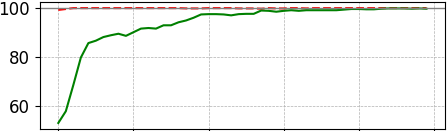

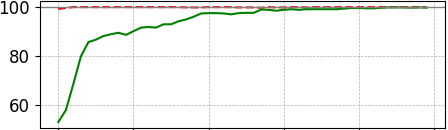

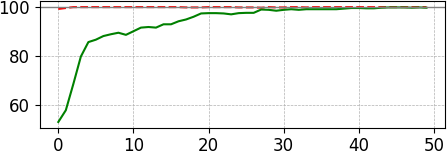

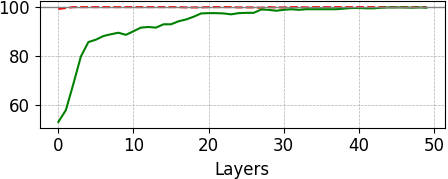

In [279]:
# left, top, right, bottom
for s in [
    (40, 105, 12, 64),
    (40, 106, 12, 64),
    (40, 106, 12, 40),
    (40, 106, 12, 15),
    (10, 80, 10, 200),
]:    
    # Trims are defined as (left, top, right, bottom)
    display(crop_image(graphs_files[0], s))  # First graph

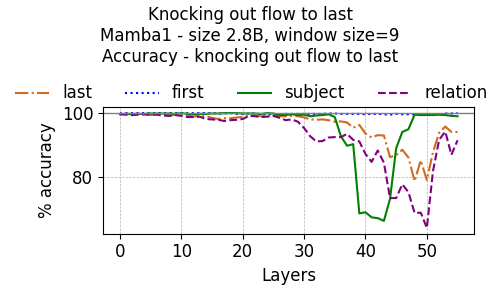

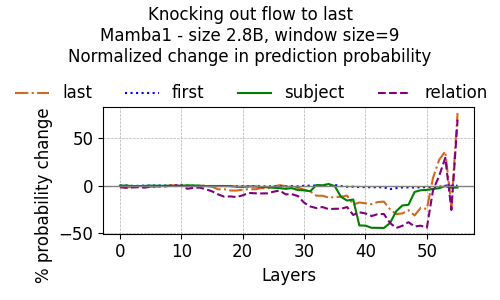

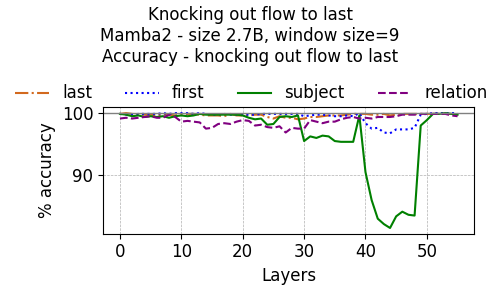

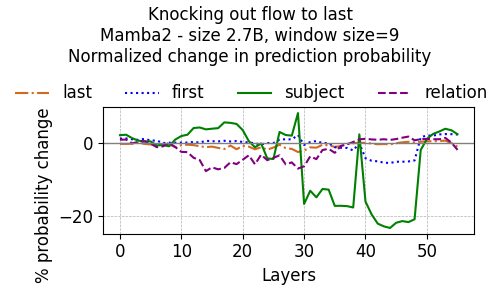

In [163]:
for g in graphs_files:
    img = Image.open(g)
    display(img)